<a href="https://colab.research.google.com/github/PashaIanko/Kaggle.ParisHousingPrices/blob/better_outlier_clean/2_data_preparation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Setup

In [1]:
from google.colab import drive
# Datasets
import pandas as pd
# Numerics
import numpy as np
# Plotting
import matplotlib.pyplot as plt
import seaborn as sns
# Preprocessing & pipelines
from sklearn.pipeline import make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
# Data management
from sklearn.model_selection import train_test_split
# Other
import os

pd.set_option('display.max_columns', None)

In [2]:
%%capture
GIT_DOWNLOAD_PATH = 'https://raw.githubusercontent.com/PashaIanko/Sklearn-Utils/main/'
FILES_LIST = [
    'path_manager.py',
    'sklearn_transformers.py',
    'sklearn_utils.py',
    'model.py'
]
GDRIVE_PATH = '/content/gdrive/MyDrive/'
PREPROC_TRIAL = 3
MODELS_TRIAL = 1
COMPETITION_PATH = GDRIVE_PATH + 'ML/Competitions/10.ParisHousePrices/'
# --------------------------------------------------
try:
    from nbpep8.nbpep8 import pep8
except ModuleNotFoundError:
    !pip install pycodestyle
    !pip install --index-url https://test.pypi.org/simple/ nbpep8
from nbpep8.nbpep8 import pep8
# ---------------------------------------
def download_files(url_dict):
    for file, url in url_dict.items():
        print(f'Downloading {file}')
        !wget -O {file} {url} {file}
url_dict = {file: GIT_DOWNLOAD_PATH + file for file in FILES_LIST}
print('a')
download_files(url_dict)
# ---------------------------------------
import importlib
import path_manager
import sklearn_utils
import sklearn_transformers
import model
def reload_all(modules_list_):
    for module in modules_list_:
        importlib.reload(module)
MODULES_LIST = [
    path_manager,
    sklearn_utils,
    sklearn_transformers,
    model
]
reload_all(MODULES_LIST)
# ---------------------------------------
from path_manager import PathManager
from model import Model
from sklearn_utils import nan_statistics
from sklearn_utils import boxplot_regression
from sklearn_utils import get_correlated_attributes
from sklearn_utils import visualize_datasets_distributions
from sklearn_transformers import ColumnDropper
from sklearn_transformers import LogTransformer
# ---------------------------------------
from google.colab import drive
drive.mount('/content/gdrive')
manager = PathManager(
    competition_path=COMPETITION_PATH,
    preprocessing_trial=PREPROC_TRIAL,
    models_trial=MODELS_TRIAL
)
manager.setup_paths()

# Download the data

In [177]:
df_source = pd.read_csv(manager.train_path, index_col='id')
df_submission = pd.read_csv(manager.test_path, index_col='id')
df_source.shape, df_submission.shape

((22730, 17), (15154, 16))

# Clean outliers

Here, we have to duplicate the code from the data_exploration.ipynb notebook

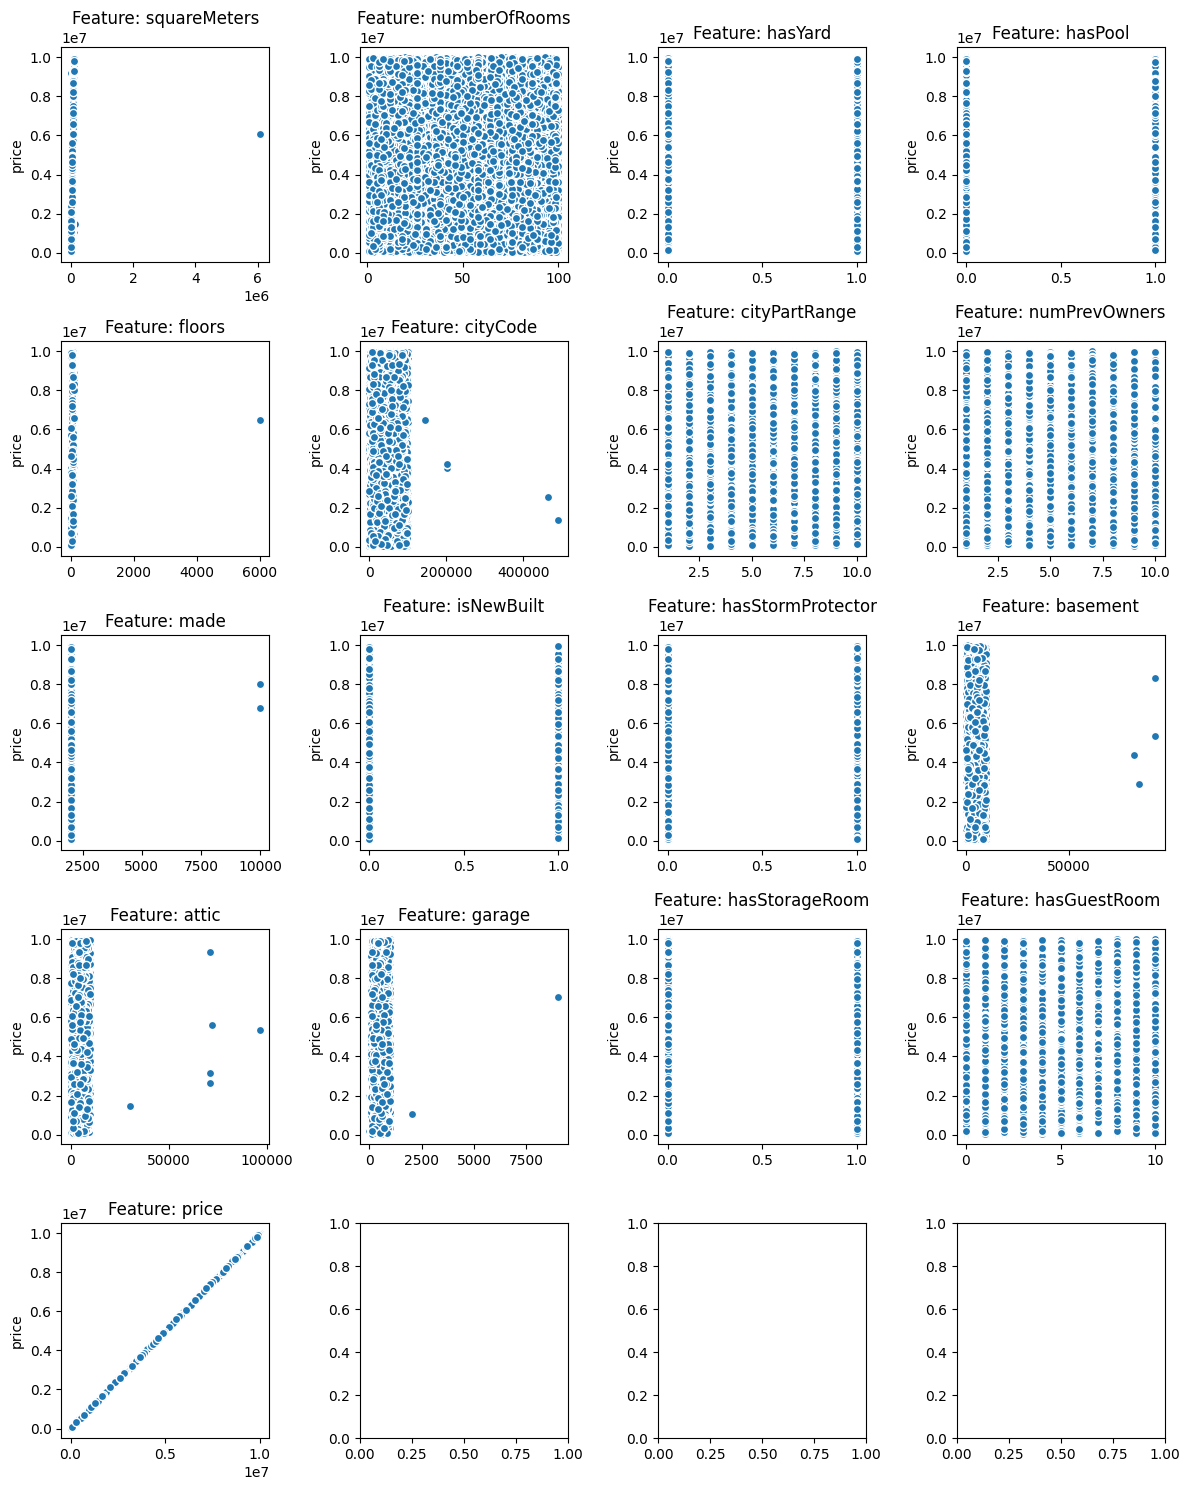

In [178]:
from sklearn_utils import visualize_target_vs_columns

visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## IQR cleaning

In [179]:
def plot_quantile_outliers(df, column_quantile_dict, n_cols=5):
    temp = len(column_quantile_dict.keys()) // n_cols
    n_rows = temp if len(column_quantile_dict.keys()) % n_cols == 0 else temp + 1

    _, ax = plt.subplots(nrows=n_rows, ncols=n_cols)
    ax = ax.flatten()
    counter = 0
    outlier_indices = list()
    for column_name, quantile in column_quantile_dict.items():

        subset = df.loc[
            df[column_name] > df_source[column_name].quantile(quantile)
        ]
        print(f'For {column_name}: {subset.shape[0]} outliers')
        print(f'Indices: {list(subset.index)}')

        outlier_indices += list(subset.index)

        ax[counter].scatter(df_source[column_name], df_source['price'])
        ax[counter].scatter(subset[column_name], subset['price'])
        ax[counter].set_ylabel('price')
        ax[counter].set_xlabel(column_name)

        counter += 1
    return set(outlier_indices)

For squareMeters: 20 outliers
Indices: [648, 2323, 3184, 3515, 4657, 4741, 5261, 8054, 8533, 10043, 13686, 14864, 15334, 15749, 17330, 17742, 19081, 19438, 19978, 21320]
For floors: 1 outliers
Indices: [5659]
For cityCode: 7 outliers
Indices: [299, 1326, 2425, 10987, 20576, 20735, 22631]
For made: 5 outliers
Indices: [2113, 3608, 19124, 19748, 21400]
For basement: 4 outliers
Indices: [2107, 3995, 15068, 18926]
For attic: 7 outliers
Indices: [3828, 4909, 12858, 13633, 13642, 17168, 19994]
For garage: 2 outliers
Indices: [14878, 17629]


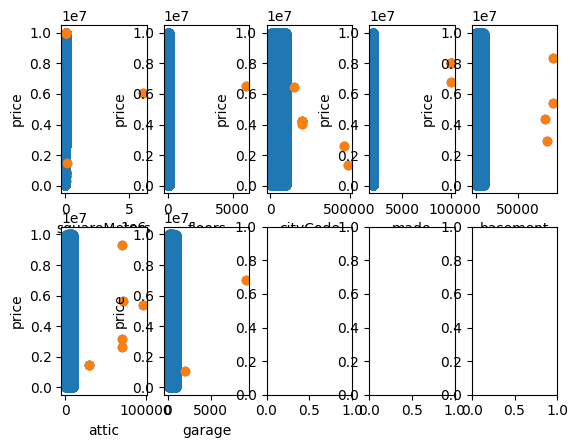

In [180]:
outlier_indices = plot_quantile_outliers(
    df_source,
    {
        'squareMeters': 0.999,
        'floors': 0.999,
        'cityCode': 0.9997,
        'made': 0.999,
        'basement': 0.9995,
        'attic': 0.9995,
        'garage': 0.999
    }
)

In [181]:
len(outlier_indices) / df_source.shape[0]

0.002023757149142103

In [182]:
print(f'Data size before IQR cleaning: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_indices), :]
print(f'Data size after IQR cleaning: {df_source.shape}')

Data size before IQR cleaning: (22730, 17)
Data size after IQR cleaning: (22684, 17)


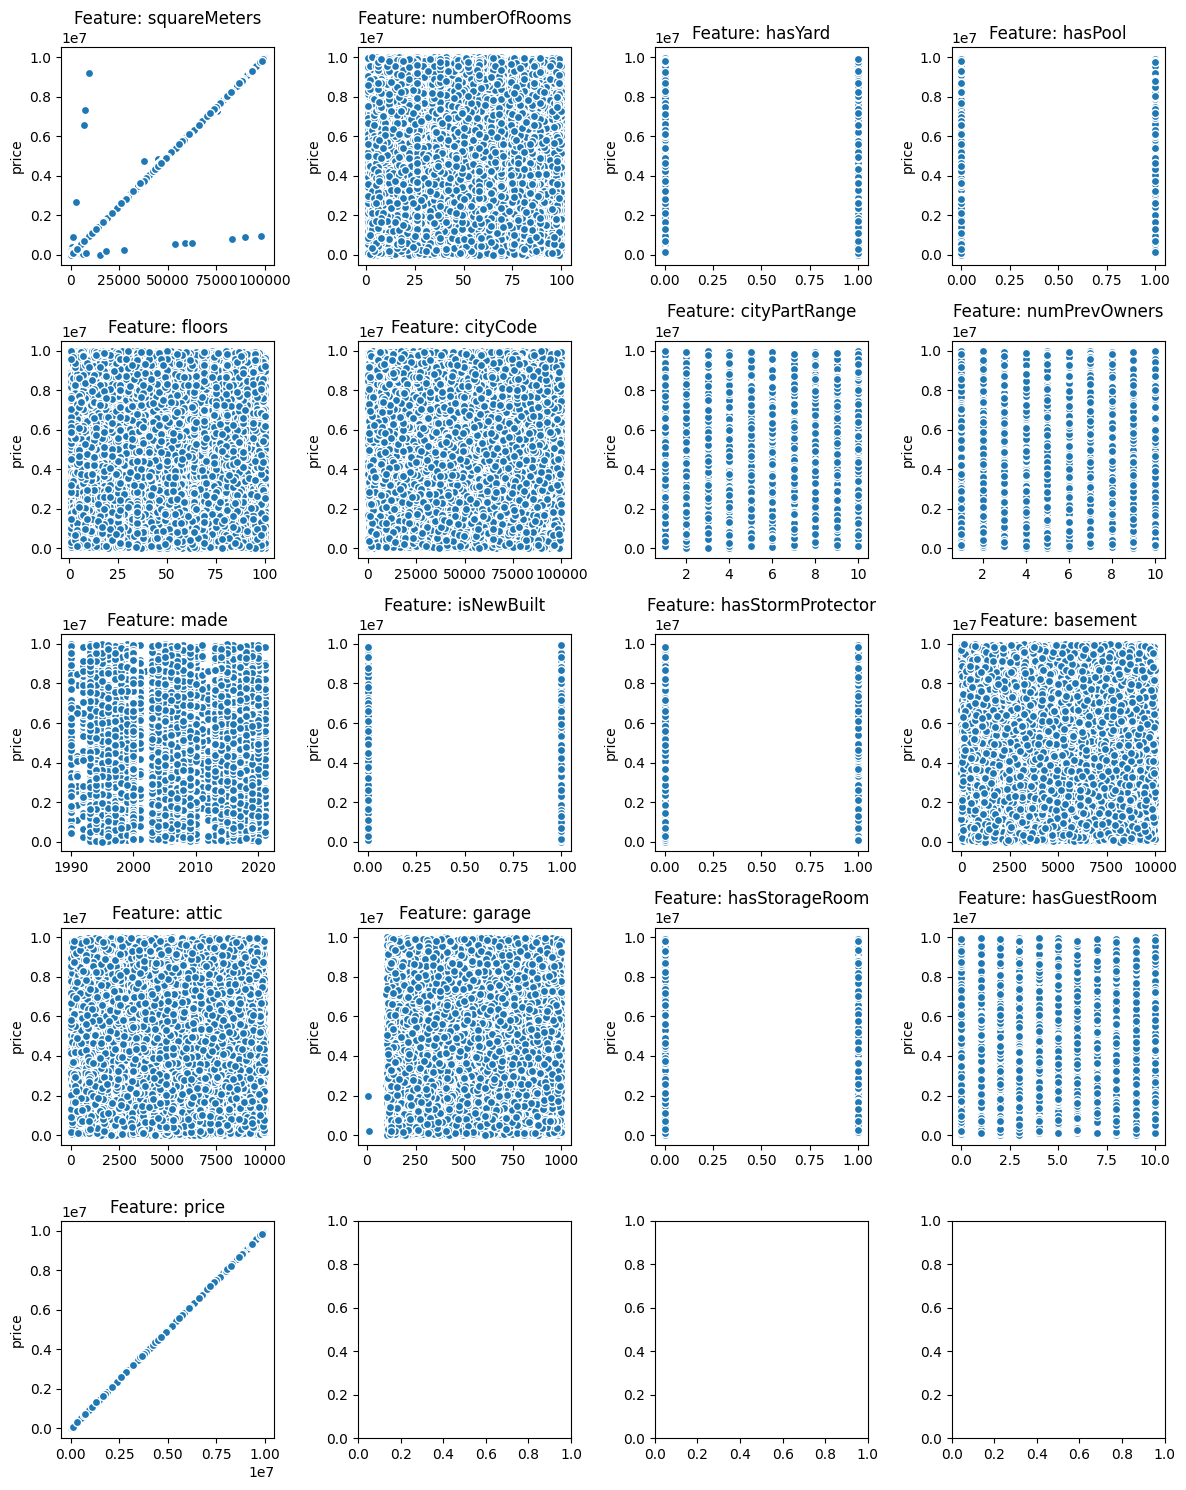

In [183]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=4,
    height_scale=3.0
)

## Local outlier factor cleaning

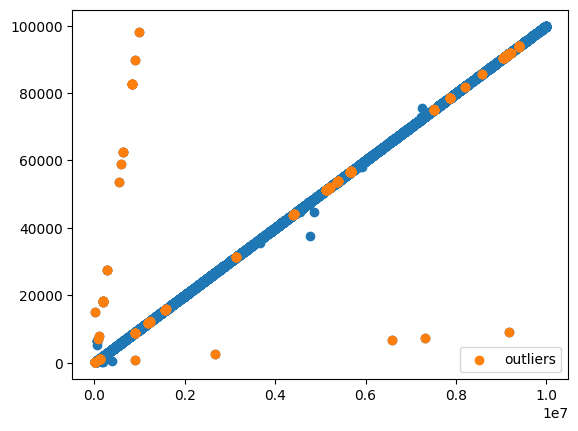

In [184]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor(n_neighbors=60)
preds = clf.fit_predict(df_source[['price', 'squareMeters']])

outlier_indices = np.where(preds == -1)[0]
outlier_subset = df_source.iloc[outlier_indices]

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])
ax.scatter(outlier_subset['price'], outlier_subset['squareMeters'], label='outliers')
ax.legend()

We will clean (244,) outliers
shape before: (22684, 17)
shape after: (22440, 17)
(22440, 17)


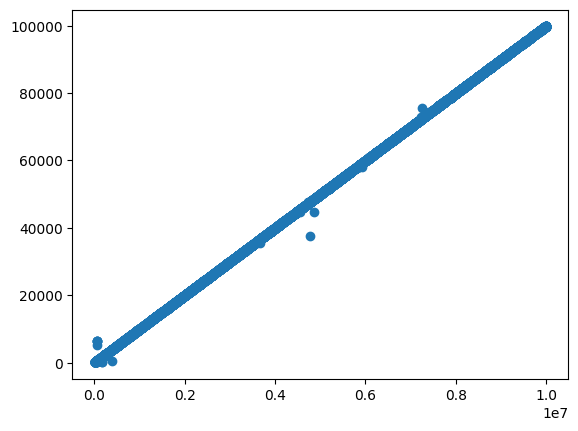

In [185]:

print(f'We will clean {outlier_indices.shape} outliers')

print(f'shape before: {df_source.shape}')
df_source = df_source.iloc[~df_source.index.isin(outlier_subset.index), :]
print(f'shape after: {df_source.shape}')

_, ax = plt.subplots()
ax.scatter(df_source['price'], df_source['squareMeters'])

print(df_source.shape)

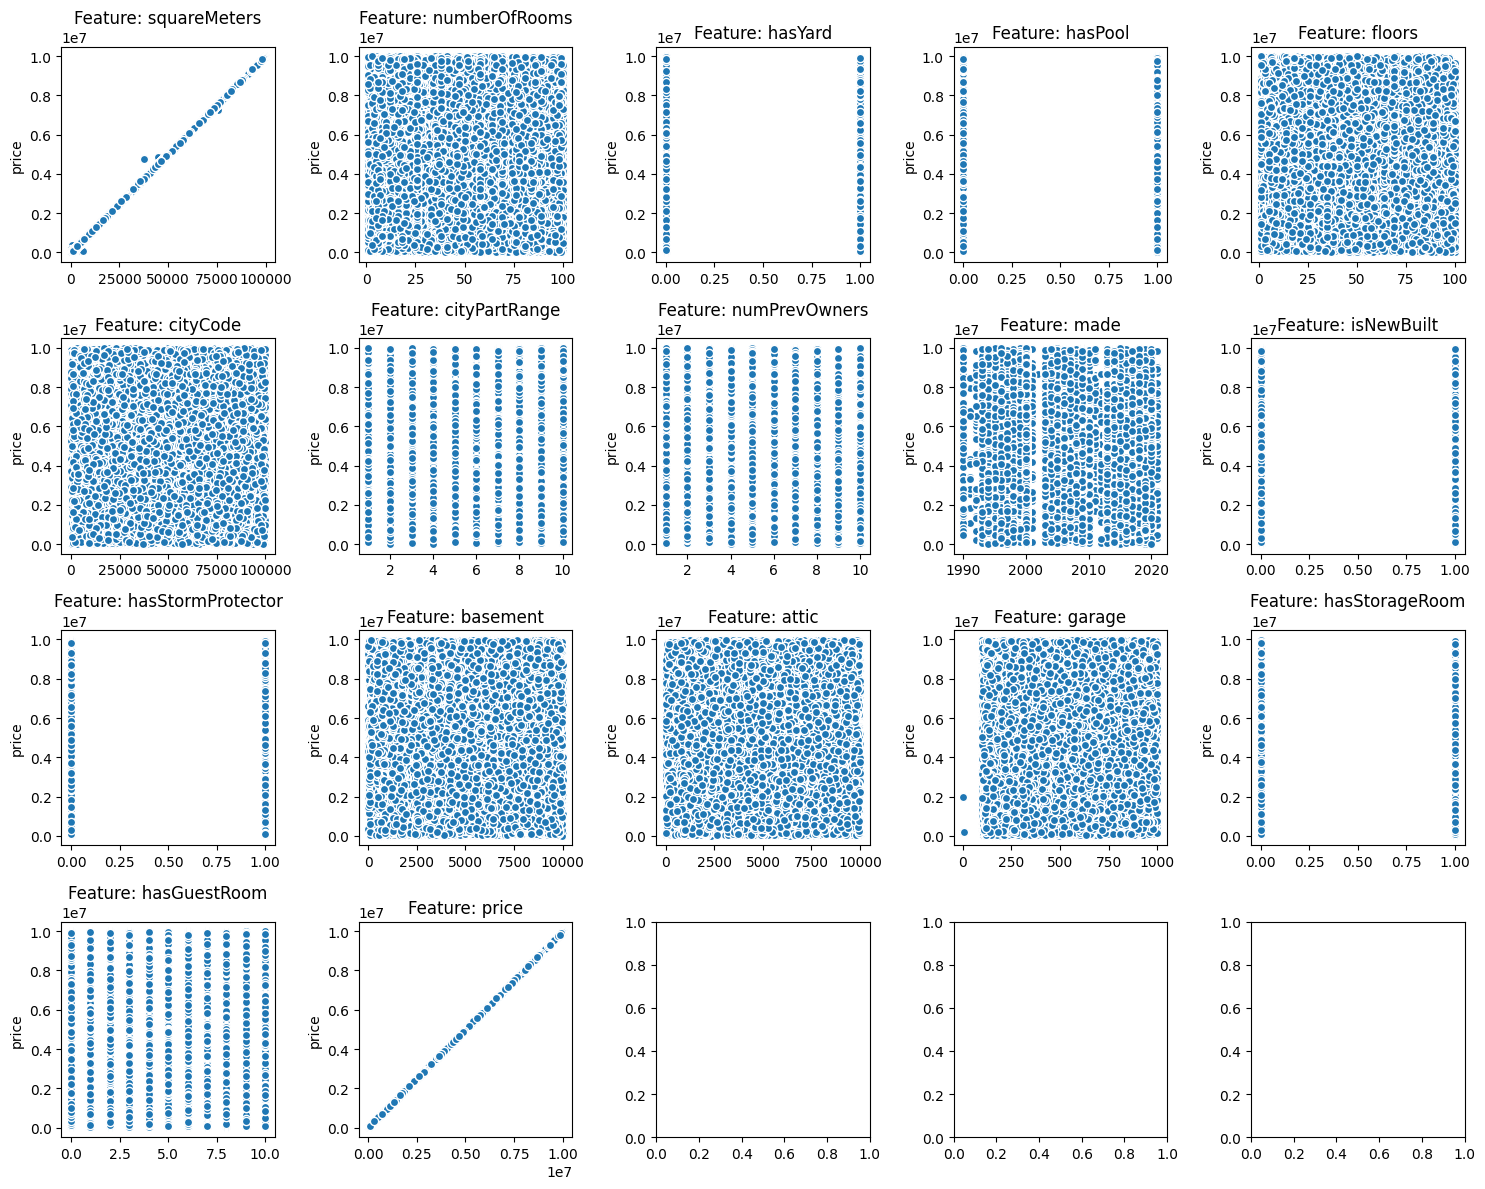

In [188]:
visualize_target_vs_columns(
    df_source,
    'price',
    df_source.columns,
    grid_width=5,
    height_scale=3.0
)

In [144]:
# (df_source['price'] / df_source['squareMeters']).mean()
# _, ax = plt.subplots()
# ax.scatter(
#     y=df_source['price'],
#     x=df_source['squareMeters']
# )
# ax.set_ylabel('price')

# x = np.linspace(df_source['squareMeters'].min(), df_source['squareMeters'].max(), 100)
# y = np.array([100.83 * x_ for x_ in x])
# OFFSET = 250000
# ax.plot(x, y + OFFSET, color='red')
# ax.plot(x, y - OFFSET, color='red')

# Split the data

In [192]:
from sklearn.model_selection import train_test_split

RANDOM_STATE = 42
TRAINVAL_SIZE = 0.8
TRAIN_SIZE = 0.8

df_trainval, df_test = train_test_split(
    df_source,
    random_state=RANDOM_STATE,
    train_size=TRAINVAL_SIZE
)

df_train, df_val = train_test_split(
    df_trainval,
    random_state=RANDOM_STATE,
    train_size=TRAIN_SIZE
)

df_train.shape, df_val.shape, df_test.shape

((14361, 17), (3591, 17), (4488, 17))

In [193]:
def X_Y(df, y=True):
    X = df.loc[:, df.columns != 'price']
    if y:
        Y = df['price']
    else:
        Y = None
    return X, Y

X_train, Y_train = X_Y(df_train)
X_val, Y_val = X_Y(df_val)
X_test, Y_test = X_Y(df_test)
X_submission, _ = X_Y(df_submission, y=False)

for x in [X_train, X_val, X_test, X_submission]:
    print(x.shape)
for y in [Y_train, Y_val, Y_test]:
    print(y.shape)

(14361, 16)
(3591, 16)
(4488, 16)
(15154, 16)
(14361,)
(3591,)
(4488,)


In [194]:
Xs = [X_train, X_val, X_test, X_submission]
Ys = [Y_train, Y_val, Y_test, None]

# Feature engineering

## Room size (square meter per room)

In [195]:
X_train.columns

Index(['squareMeters', 'numberOfRooms', 'hasYard', 'hasPool', 'floors',
       'cityCode', 'cityPartRange', 'numPrevOwners', 'made', 'isNewBuilt',
       'hasStormProtector', 'basement', 'attic', 'garage', 'hasStorageRoom',
       'hasGuestRoom'],
      dtype='object')

In [196]:
f = 'squareMeterPerRoom'

def add_square_meter_per_room(df):
    df[f] = df['squareMeters'] / df['numberOfRooms']


for i, x in enumerate(Xs):
    print(Xs[i].shape)
    x = add_square_meter_per_room(x)
    print(Xs[i].shape)

(14361, 16)
(14361, 17)
(3591, 16)
(3591, 17)
(4488, 16)
(4488, 17)
(15154, 16)
(15154, 17)


## Feature cross for boolean variables

In [197]:
def add_category(df):
    df['ApartmentCharacteristic'] = df.apply(
        lambda item: f'{int(item["hasYard"])}x{int(item["hasPool"])}x{int(item["isNewBuilt"])}x{int(item["hasStormProtector"])}x{int(item["hasStorageRoom"])}',
        axis='columns'
    )
    return df

for i, data in enumerate(Xs):
    print('Shape before', data.shape)
    data = add_category(data)
    print('Shape after', Xs[i].shape)

Shape before (14361, 17)
Shape after (14361, 18)
Shape before (3591, 17)
Shape after (3591, 18)
Shape before (4488, 17)
Shape after (4488, 18)
Shape before (15154, 17)
Shape after (15154, 18)


In [198]:
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder

encoder = OneHotEncoder()
encoder.fit(Xs[0][['ApartmentCharacteristic']])
encoder.categories_, len(encoder.categories_[0])

([array(['0x0x0x0x0', '0x0x0x0x1', '0x0x0x1x0', '0x0x0x1x1', '0x0x1x0x0',
         '0x0x1x0x1', '0x0x1x1x0', '0x0x1x1x1', '0x1x0x0x0', '0x1x0x0x1',
         '0x1x0x1x0', '0x1x0x1x1', '0x1x1x0x0', '0x1x1x0x1', '0x1x1x1x0',
         '0x1x1x1x1', '1x0x0x0x0', '1x0x0x0x1', '1x0x0x1x0', '1x0x0x1x1',
         '1x0x1x0x0', '1x0x1x0x1', '1x0x1x1x0', '1x0x1x1x1', '1x1x0x0x0',
         '1x1x0x0x1', '1x1x0x1x0', '1x1x0x1x1', '1x1x1x0x0', '1x1x1x0x1',
         '1x1x1x1x0', '1x1x1x1x1'], dtype=object)],
 32)

In [199]:
def do_feature_cross(df, column_name, trained_one_hot_encoder):
    assert column_name in df.columns, print(f'{column_name} is not in columns')

    categories_in_df = df[column_name].unique()
    for cat in categories_in_df:
        assert cat in trained_one_hot_encoder.categories_[0], \
            print(f'Category {cat} is not learned, but is in the dataframe')

    print(f'NANs before preprocessing: {df.isna().sum().sum()}')
    transformed_df = pd.DataFrame(encoder.transform(df[[column_name]]).toarray())

    # Aligning index to avoid NAN after join
    transformed_df.index = df.index
    df = df.join(transformed_df)
    df.columns = df.columns.astype(str)
    print(f'NANs after preprocessing: {df.isna().sum().sum()}')
    return df

In [200]:
for i in range(len(Xs)):
    print(f'Working with {i}')
    print(f'Shape before: {Xs[i].shape}')
    Xs[i] = do_feature_cross(Xs[i], 'ApartmentCharacteristic', encoder)
    print(f'Shape after:', Xs[i].shape)
    print()

Working with 0
Shape before: (14361, 18)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (14361, 50)

Working with 1
Shape before: (3591, 18)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (3591, 50)

Working with 2
Shape before: (4488, 18)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (4488, 50)

Working with 3
Shape before: (15154, 18)
NANs before preprocessing: 0
NANs after preprocessing: 0
Shape after: (15154, 50)



# Preprocessing pipeline

In [201]:
for item in Xs:
    print(item.shape)

(14361, 50)
(3591, 50)
(4488, 50)
(15154, 50)


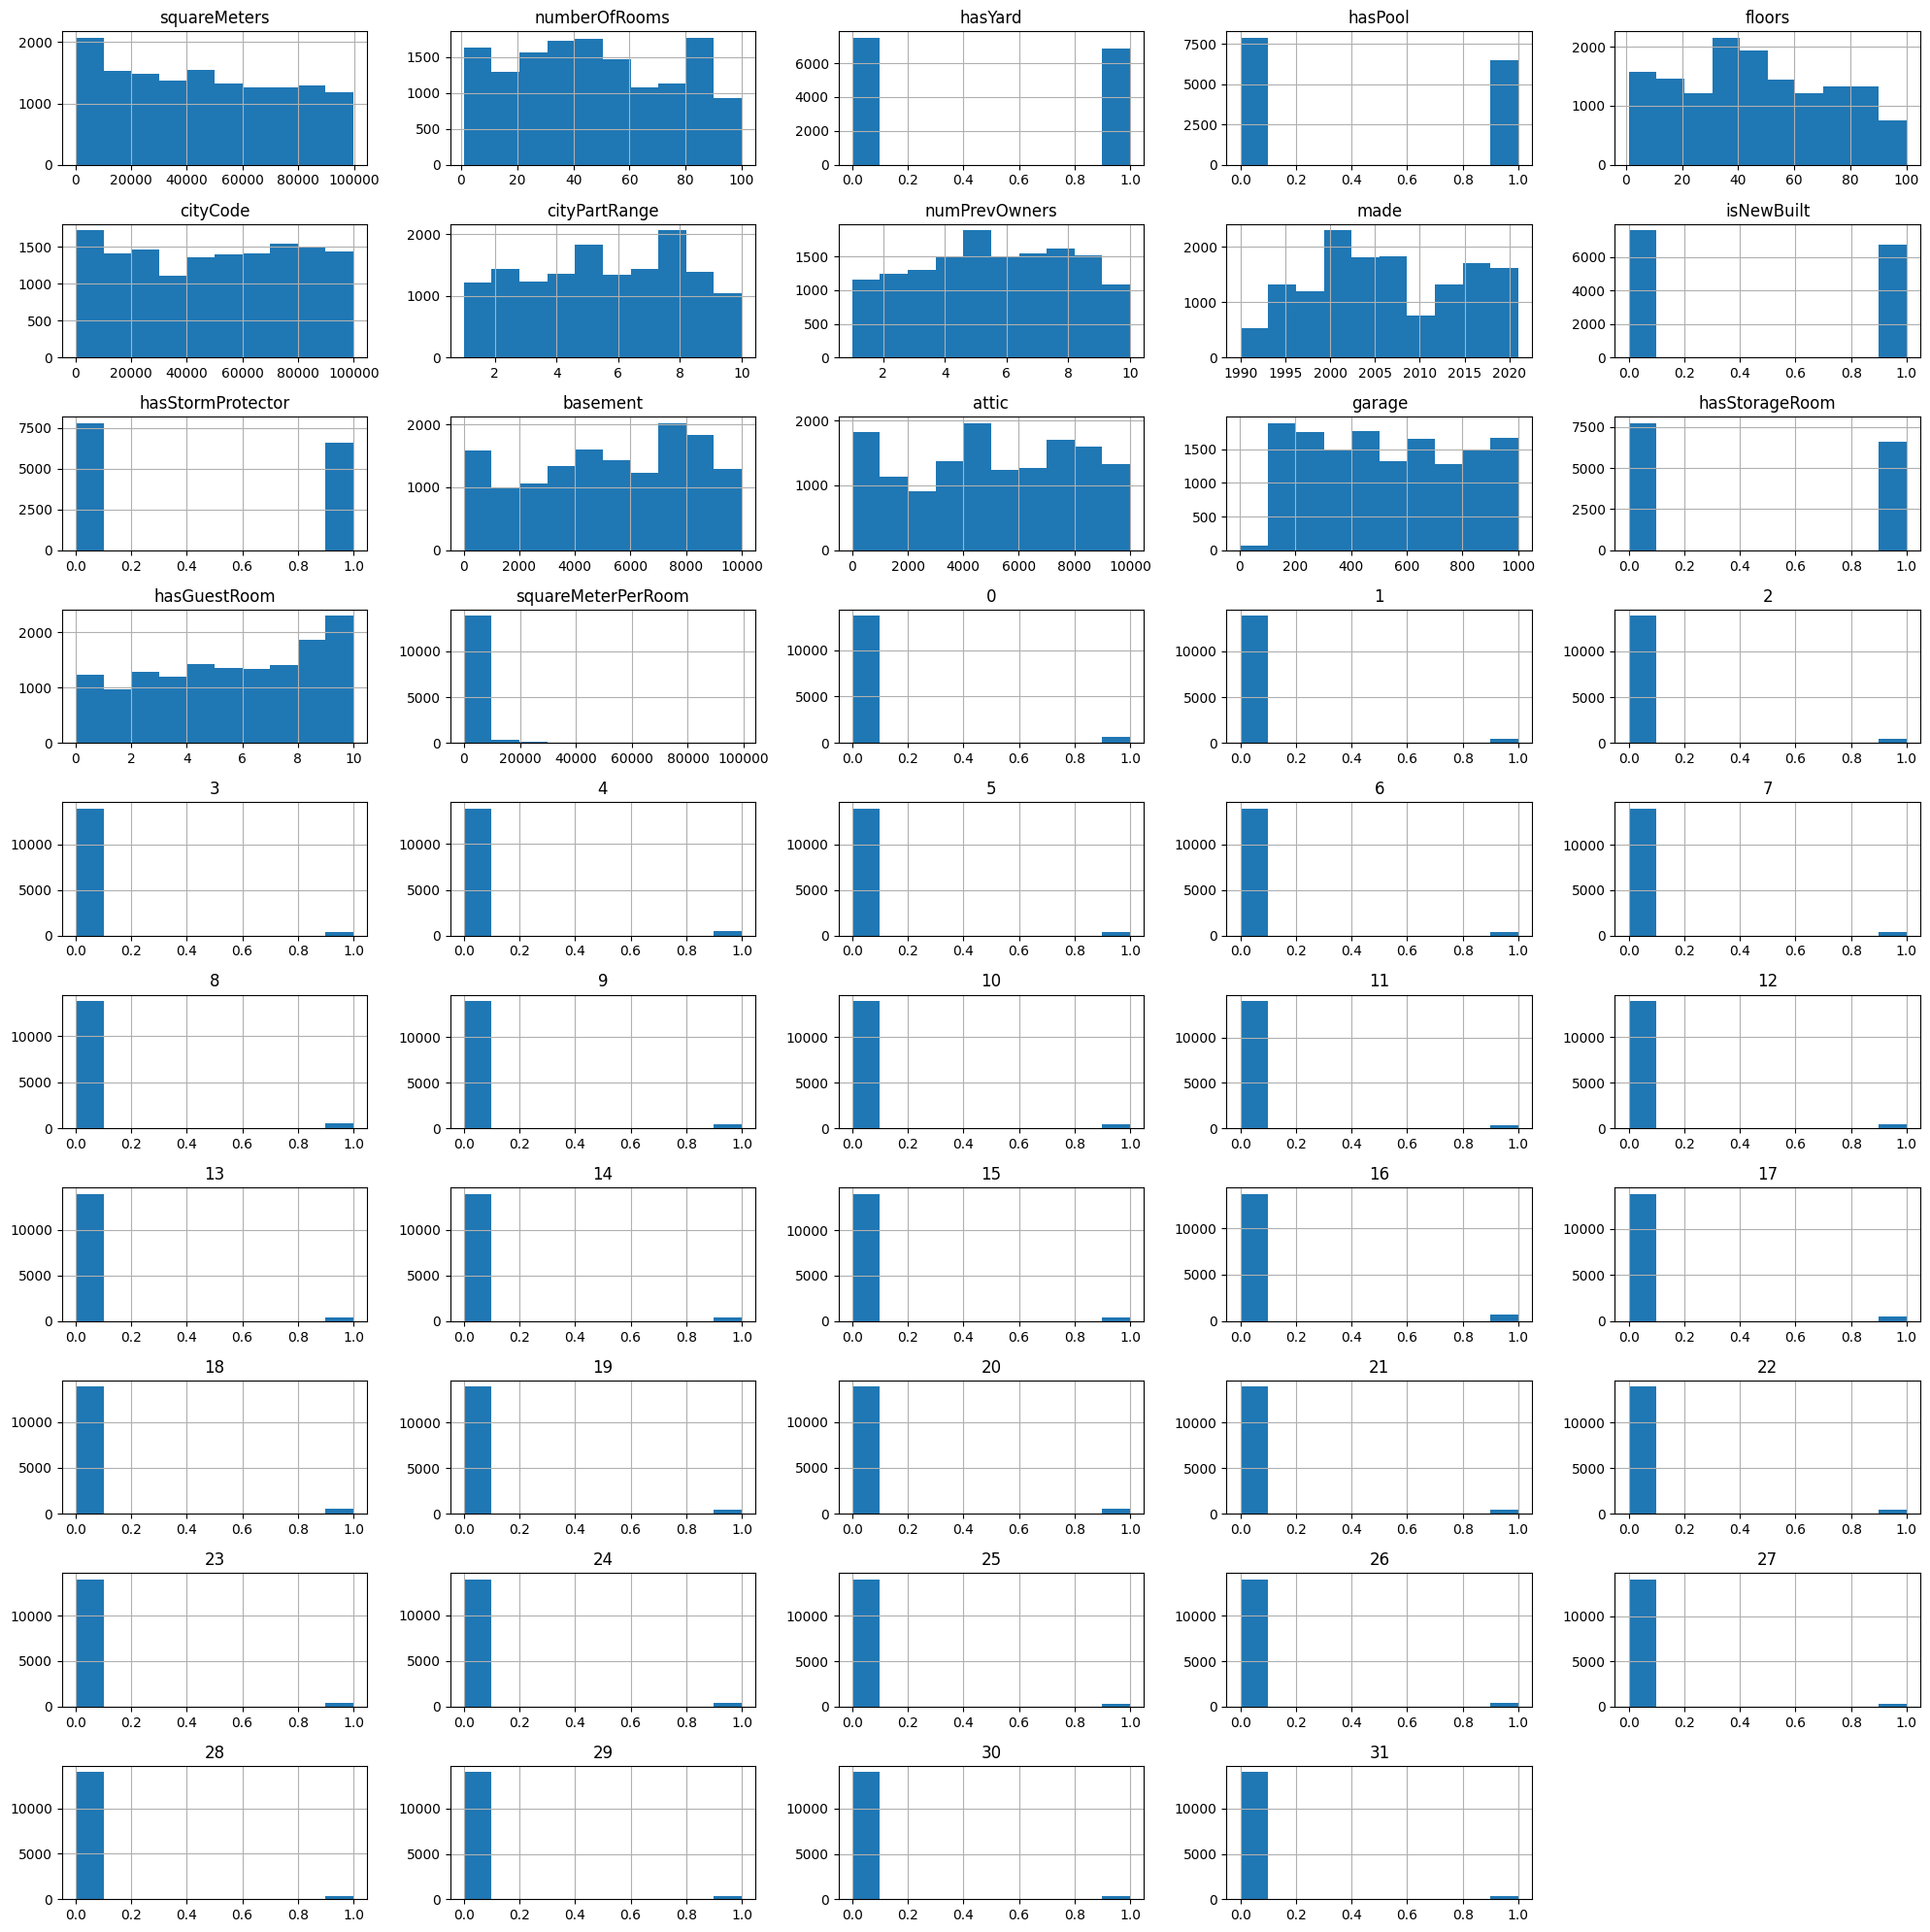

In [202]:
_ = Xs[0].hist(figsize=(20, 20), layout=(10, 5))
plt.tight_layout()

In [203]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler

num_cols = [
    #
]

cols_to_min_max_scale = [
    'squareMeters',
    'numberOfRooms',
    'floors',
    'cityPartRange',
    'numPrevOwners',
    'made',
    'basement',
    'attic',
    'garage',
    'hasGuestRoom',
    'hasYard',
    'hasPool',
    'isNewBuilt',
    'hasStormProtector',
    'hasStorageRoom',
    *[str(i) for i in range(0, 32)]
]

cols_to_drop = [
    'cityCode',
    'ApartmentCharacteristic',
    'squareMeterPerRoom'
]

In [204]:
total_cols = set(
    [
        *num_cols,
        *cols_to_min_max_scale,
        *cols_to_drop
    ]
)

for i in range(len(Xs)):
    assert set(Xs[i].columns) - total_cols == set()

In [205]:
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler

num_pipeline = make_pipeline(
    StandardScaler()
)

min_max_pipeline = make_pipeline(
    MinMaxScaler()
)

preprocessor = ColumnTransformer(
    transformers=[
        # ('num', num_pipeline, num_cols),
        ('min_max', min_max_pipeline, cols_to_min_max_scale),
        # ()
    ],
    remainder='drop'
)

In [206]:
for i in range(len(Xs)):
    print(f'Shape before: {Xs[i].shape}')
    if i == 0:
        Xs[i] = preprocessor.fit_transform(Xs[i])  # train set
    else:
        Xs[i] = preprocessor.transform(Xs[i])
    print(f'Shape after: {Xs[i].shape}')
    print()

Shape before: (14361, 50)
Shape after: (14361, 47)

Shape before: (3591, 50)
Shape after: (3591, 47)

Shape before: (4488, 50)
Shape after: (4488, 47)

Shape before: (15154, 50)
Shape after: (15154, 47)



# Save the data

In [207]:
manager.data_trial_path

'/content/gdrive/MyDrive/ML/Competitions/10.ParisHousePrices/Data/preproc_trial_3'

In [208]:
Ys[0].shape, np.expand_dims(Ys[0], axis=0).shape

((14361,), (1, 14361))

In [209]:
for i in range(len(Xs)):
    print(Xs[i].shape)
    if Ys[i] is not None:
        Xs[i] = np.hstack([Xs[i], np.expand_dims(Ys[i], axis=-1)])
    print(Xs[i].shape)
    print()

(14361, 47)
(14361, 48)

(3591, 47)
(3591, 48)

(4488, 47)
(4488, 48)

(15154, 47)
(15154, 47)



In [210]:
manager.save_to_csv(Xs[0], path_=manager.data_trial_path, file_name_='train_processed.csv')
manager.save_to_csv(Xs[1], path_=manager.data_trial_path, file_name_='val_processed.csv')
manager.save_to_csv(Xs[2], path_=manager.data_trial_path, file_name_='test_processed.csv')
manager.save_to_csv(Xs[3], path_=manager.data_trial_path, file_name_='submission_processed.csv')

# Conclusions

- Removed cityCode column - it is generated, so not mapped into real Paris city zones -> does not make a lot of sense